In [48]:
import numpy as np
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [49]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

df.columns = df.columns.str.lower().str.replace(' ','_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ','_')

df.totalcharges = pd.to_numeric(df.totalcharges,errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)


In [50]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [51]:
df_full_train,df_test = train_test_split(df,test_size=0.2,random_state=1)
df_train, df_val = train_test_split(df_full_train,test_size=0.25,random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_test = df_test.churn.values
y_val = df_val.churn.values

del df_train['churn']
del df_test['churn']
del df_val['churn']

df_full_train.reset_index(drop=True)



,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,...,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,5442-pptjy,male,0,yes,yes,12,yes,no,no,no_internet_service,...,no_internet_service,no_internet_service,no_internet_service,no_internet_service,two_year,no,mailed_check,19.70,258.35,0
1,6261-rcvns,female,0,no,no,42,yes,no,dsl,yes,...,yes,yes,no,yes,one_year,no,credit_card_(automatic),73.90,3160.55,1
2,2176-osjuv,male,0,yes,no,71,yes,yes,dsl,yes,...,no,yes,no,no,two_year,no,bank_transfer_(automatic),65.15,4681.75,0
3,6161-erdgd,male,0,yes,yes,71,yes,yes,dsl,yes,...,yes,yes,yes,yes,one_year,no,electronic_check,85.45,6300.85,0
4,2364-ufrom,male,0,no,no,30,yes,no,dsl,yes,...,no,yes,yes,no,one_year,no,electronic_check,70.40,2044.75,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5629,0781-lkxbr,male,1,no,no,9,yes,yes,fiber_optic,no,...,yes,no,yes,yes,month-to-month,yes,electronic_check,100.50,918.60,1
5630,3507-gasnp,male,0,no,yes,60,yes,no,no,no_internet_service,...,no_internet_service,no_internet_service,no_internet_service,no_internet_service,two_year,no,mailed_check,19.95,1189.90,0
5631,8868-wozgu,male,0,no,no,28,yes,yes,fiber_optic,no,...,yes,no,yes,yes,month-to-month,yes,electronic_check,105.70,2979.50,1
5632,1251-krreg,male,0,no,no,2,yes,yes,dsl,no,...,no,no,no,no,month-to-month,yes,mailed_check,54.40,114.10,1


In [52]:
numerical = ['tenure','monthlycharges','totalcharges']

categorical = ['gender', 'seniorcitizen', 'partner', 'dependents',
       'phoneservice', 'multiplelines', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling',
       'paymentmethod']



In [53]:
train_dicts = df_train[categorical+numerical].to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

model = LogisticRegression()
model.fit(X_train,y_train)

LogisticRegression()

In [54]:
val_dicts = df_val[categorical+numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

y_pred = model.predict_proba(X_val)[:,1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

0.8034066713981547

In [55]:
from sklearn.metrics import accuracy_score

In [56]:
thresholds = np.linspace(0,1,21)

scores = []
for t in thresholds:
    score = accuracy_score(y_val,y_pred >= t)
    scores.append(score)

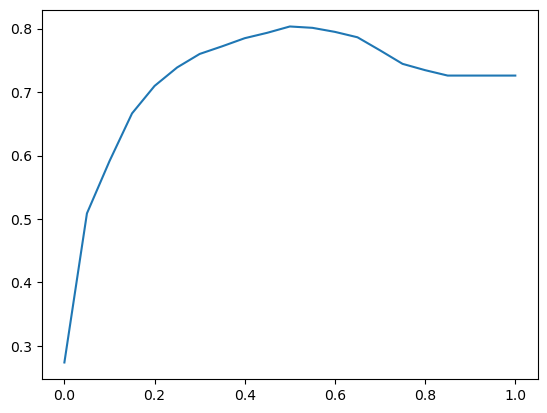

In [57]:
plt.plot(thresholds,scores)

In [58]:
from collections import Counter
Counter(y_pred>=1.0)

Counter({False: 1409})

In [59]:
Counter(y_val)

Counter({0: 1023, 1: 386})

In [60]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [64]:
t = 0.5
predict_postive = (y_pred >=t)
predict_negative = (y_pred < t)

In [65]:
TP = (actual_positive & predict_postive).sum()
TN = (actual_negative & predict_negative).sum()
FN = (actual_positive & predict_negative).sum()
FP = (actual_negative & predict_postive).sum()

In [66]:
TP,TN,FP,FN

(210, 922, 101, 176)

In [67]:
confusion_matrix = np.array([[TN,FP],[FN,TP]])

In [70]:
(confusion_matrix/confusion_matrix.sum()).round(2)

array([[0.65, 0.07],
       [0.12, 0.15]])

In [73]:
precision = TP/(TP+FP)
precision

0.6752411575562701

In [74]:
Recall = TP/(TP+FN)
Recall

0.5440414507772021

In [76]:
TPR = TP/(TP+FN)
TPR

0.5440414507772021

In [77]:
FPR = FP/(TN+FP)
FPR

0.09872922776148582

In [78]:
threshold = np.linspace(0,1,101)
scores = []
for t in threshold:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predict_postive = (y_pred >=t)
    predict_negative = (y_pred < t)

    TP = (actual_positive & predict_postive).sum()
    TN = (actual_negative & predict_negative).sum()
    FN = (actual_positive & predict_negative).sum()
    FP = (actual_negative & predict_postive).sum()
    scores.append((t,TP,TN,FN,FP))

In [81]:
columns = ['threshold','TP','TN','FN','FP']
df_scores = pd.DataFrame(scores,columns=columns)

In [86]:
df_scores['tpr'] = df_scores.TP/(df_scores.TP + df_scores.FN)
df_scores['fpr'] = df_scores.FP/(df_scores.TN + df_scores.FP)

In [88]:
df_scores[::10]

,threshold,TP,TN,FN,FP,tpr,fpr
0,0.0,386,0,0,1023,1.000000,1.000000
10,0.1,366,467,20,556,0.948187,0.543500
20,0.2,333,667,53,356,0.862694,0.347996
30,0.3,284,787,102,236,0.735751,0.230694
40,0.4,249,857,137,166,0.645078,0.162268
50,0.5,210,922,176,101,0.544041,0.098729
60,0.6,150,970,236,53,0.388601,0.051808
70,0.7,76,1003,310,20,0.196891,0.019550
80,0.8,13,1022,373,1,0.033679,0.000978
90,0.9,0,1023,386,0,0.000000,0.000000


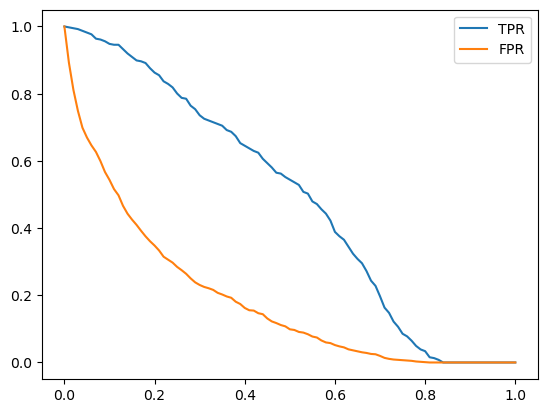

In [90]:
plt.plot(df_scores.threshold,df_scores['tpr'],label='TPR')
plt.plot(df_scores.threshold,df_scores['fpr'],label='FPR')
plt.legend()

In [91]:
np.random.seed(1)
y_rand = np.random.uniform(0,1,size=len(y_val))

In [92]:
((y_rand >= 0.5) == y_val).mean()

0.5017743080198722

In [93]:
def tpr_fpr_dataframe(y_val,y_pred):
    threshold = np.linspace(0,1,101)
    scores = []
    for t in threshold:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)
    
        predict_postive = (y_pred >=t)
        predict_negative = (y_pred < t)
    
        TP = (actual_positive & predict_postive).sum()
        TN = (actual_negative & predict_negative).sum()
        FN = (actual_positive & predict_negative).sum()
        FP = (actual_negative & predict_postive).sum()
        scores.append((t,TP,TN,FN,FP))
    columns = ['threshold','TP','TN','FN','FP']
    df_scores = pd.DataFrame(scores,columns=columns)
    df_scores['tpr'] = df_scores.TP/(df_scores.TP + df_scores.FN)
    df_scores['fpr'] = df_scores.FP/(df_scores.TN + df_scores.FP)

    return df_scores

In [94]:
df_rand = tpr_fpr_dataframe(y_val,y_rand)

In [95]:
df_rand[::10]

,threshold,TP,TN,FN,FP,tpr,fpr
0,0.0,386,0,0,1023,1.000000,1.000000
10,0.1,347,100,39,923,0.898964,0.902248
20,0.2,307,201,79,822,0.795337,0.803519
30,0.3,276,299,110,724,0.715026,0.707722
40,0.4,237,399,149,624,0.613990,0.609971
50,0.5,202,505,184,518,0.523316,0.506354
60,0.6,161,614,225,409,0.417098,0.399804
70,0.7,121,721,265,302,0.313472,0.295210
80,0.8,78,817,308,206,0.202073,0.201369
90,0.9,40,922,346,101,0.103627,0.098729


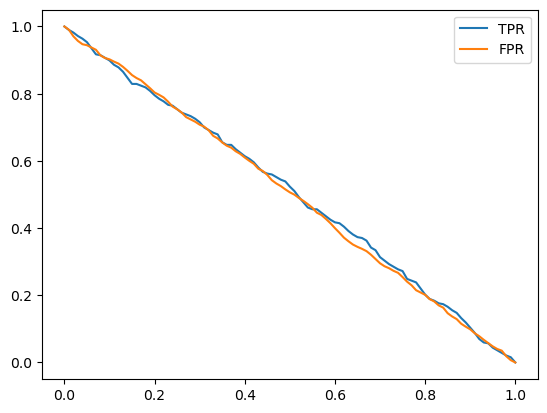

In [98]:
plt.plot(df_rand.threshold,df_rand['tpr'],label='TPR')
plt.plot(df_rand.threshold,df_rand['fpr'],label='FPR')
plt.legend()

In [99]:
num_ned = (y_val == 0).sum()
num_pos = (y_val == 1).sum()
num_ned,num_pos

(1023, 386)

In [100]:
y_ideal = np.repeat([0,1],[num_ned,num_pos])
y_ideal

array([0, 0, 0, ..., 1, 1, 1])

In [101]:
y_ideal_pred = np.linspace(0,1,len(y_val))

In [103]:
((y_ideal_pred >= 0.726) == y_ideal).mean()

1.0

In [104]:
df_ideal = tpr_fpr_dataframe(y_ideal,y_ideal_pred)

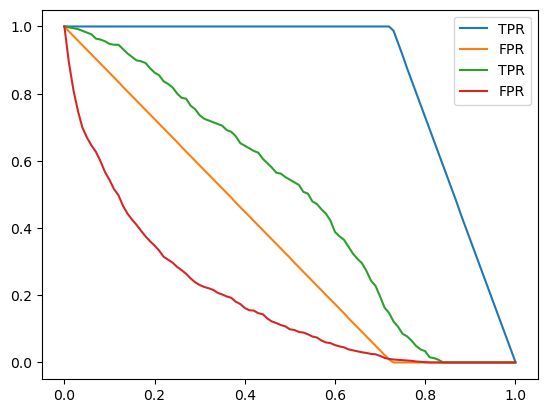

In [108]:
plt.plot(df_ideal.threshold,df_ideal['tpr'],label='TPR')
plt.plot(df_ideal.threshold,df_ideal['fpr'],label='FPR')

# plt.plot(df_rand.threshold,df_rand['tpr'],label='TPR')
# plt.plot(df_rand.threshold,df_rand['fpr'],label='FPR')

plt.plot(df_scores.threshold,df_scores['tpr'],label='TPR')
plt.plot(df_scores.threshold,df_scores['fpr'],label='FPR')


plt.legend()

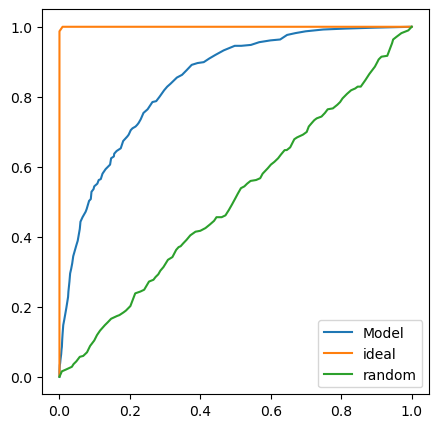

In [112]:
plt.figure(figsize=(5,5))
plt.plot(df_scores.fpr,df_scores.tpr,label = 'Model')
plt.plot(df_ideal.fpr,df_ideal.tpr,label='ideal')
plt.plot(df_rand.fpr,df_rand.tpr,label='random')
plt.legend()

In [113]:
from sklearn.metrics import roc_curve

In [114]:
fpr,tpr,thresholdsroc_curve(y_val,y_pred)

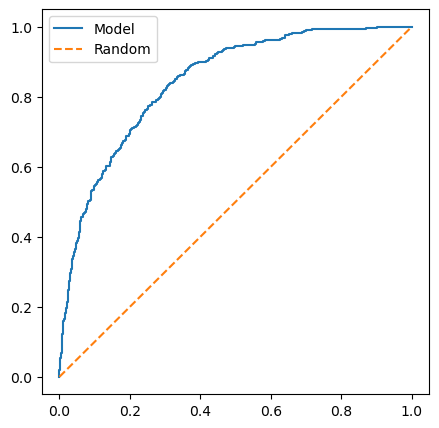

In [115]:
plt.figure(figsize=(5,5))
plt.plot(fpr,tpr,label = 'Model')
plt.plot([0,1],[0,1],label='Random',linestyle ='--')
plt.legend()

In [116]:
from sklearn.metrics import auc

In [117]:
auc(fpr,tpr)

0.8438530381535563

In [118]:
from sklearn.metrics import roc_auc_score

In [119]:
roc_auc_score(y_val,y_pred)

0.8438530381535563

In [123]:
neg = y_pred[y_val == 0]
pos = y_pred[y_val == 1]
import random
n=100000
success = 0
for i in range(n):
    pos_ind = random.randint(0,len(pos)-1)
    neg_ind = random.randint(0,len(neg)-1)
    if pos[pos_ind]> neg[neg_ind]:
        success +=1
success/n

0.84423

In [164]:
def train(df_train,y_train,C=1.0):
    dicts= df_train[categorical+numerical].to_dict(orient='records')

    dv= DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train,y_train)

    return dv,model

In [165]:
dv, model = train(df_train,y_train,C=10)

In [166]:
def predict(df,dv,model):
    dicts = df[categorical+numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:,1]
    return y_pred

In [167]:
y_pred = predict(df_val,dv,model)

In [168]:
from sklearn.model_selection import KFold

In [142]:
kfold = KFold(n_splits=10,shuffle=True,random_state=1)

In [144]:
from tqdm.auto import tqdm

In [176]:
n_splits = 5
for c in [0.000001,0.001,0.01,0.1,0.5,1.0,5.0,10.00]:

    scores = []
    
    for train_idx, val_idx in tqdm(kfold.split(df_full_train),total=n_splits):
        
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
        
        y_train = df_train.churn.values
        y_val = df_val.churn.values
        
        dv, model = train(df_train, y_train,C=c)
        y_pred = predict(df_val, dv, model)
        
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
    print('C=%s %.3f +- %.3f' %(c,np.mean(scores),np.std(scores)))

  0%|          | 0/5 [00:00<?, ?it/s]

C=1e-06 0.776 +- 0.025


  0%|          | 0/5 [00:00<?, ?it/s]

C=0.001 0.826 +- 0.012


  0%|          | 0/5 [00:00<?, ?it/s]

C=0.01 0.841 +- 0.012


  0%|          | 0/5 [00:00<?, ?it/s]

C=0.1 0.841 +- 0.012


  0%|          | 0/5 [00:00<?, ?it/s]

C=0.5 0.842 +- 0.011


  0%|          | 0/5 [00:00<?, ?it/s]

C=1.0 0.840 +- 0.013


  0%|          | 0/5 [00:00<?, ?it/s]

C=5.0 0.841 +- 0.012


  0%|          | 0/5 [00:00<?, ?it/s]

C=10.0 0.841 +- 0.012


In [177]:
dv, model = train(df_full_train, df_full_train.churn,C=0.5)
y_pred = predict(df_test, dv, model)
        
auc = roc_auc_score(y_test, y_pred)

In [178]:
auc

0.8589015459282612

In [184]:
df_full_train[0:1].to_dict()

{'customerid': {1814: '5442-pptjy'},
 'gender': {1814: 'male'},
 'seniorcitizen': {1814: 0},
 'partner': {1814: 'yes'},
 'dependents': {1814: 'yes'},
 'tenure': {1814: 12},
 'phoneservice': {1814: 'yes'},
 'multiplelines': {1814: 'no'},
 'internetservice': {1814: 'no'},
 'onlinesecurity': {1814: 'no_internet_service'},
 'onlinebackup': {1814: 'no_internet_service'},
 'deviceprotection': {1814: 'no_internet_service'},
 'techsupport': {1814: 'no_internet_service'},
 'streamingtv': {1814: 'no_internet_service'},
 'streamingmovies': {1814: 'no_internet_service'},
 'contract': {1814: 'two_year'},
 'paperlessbilling': {1814: 'no'},
 'paymentmethod': {1814: 'mailed_check'},
 'monthlycharges': {1814: 19.7},
 'totalcharges': {1814: 258.35},
 'churn': {1814: 0}}